# Regularization

- Penalizes weights being large.
- $J(w,b) = \dfrac{1}{m}\displaystyle\sum_{i=1}^{m}L(\hat{y}^{(i)}, y^{(i))}) + \dfrac{\lambda}{2m}||w||^{2}$
- Where $||w||^{2} = \displaystyle\sum_{j=1}^{n_{x}}w_{j}^{2} = w^{T}w$

In general
- $J(w^{[1]},b^{[1]} \dots w^{[2]},b^{[2]}) = \dfrac{1}{m}\displaystyle\sum_{i=1}^{m}L(\hat{y}^{(i)}, y^{(i))}) + \dfrac{\lambda}{2m}\displaystyle\sum_{l=1}^{L}||w^{[l]}||_{F}^{2}$
- Where $||w^{[l]}||_{F}^{2} = \displaystyle\sum_{i=1}^{n^{[l-1]}}\displaystyle\sum_{j=1}^{n^{[l]}}(w_{ij}^{[l]})^{2}$
- Add $\dfrac{\lambda}{m}w^{[l]}$ to $dw^{[l]}$
- $w^{[l]} = w^{[l]} - \alpha dw^{[l]}$ remains the same.

## Dropout

Example: $l =3$
- keep_prop = 0.8 (20% chance that units will be shutdown)
- d3 = np.random.rand(a3.shape[0], a3.shape[1]) $\gt$ keep_prop
- a3 = np.multiply(a3, d3)
- a3 = a3 / keep_prop

Other regularization
- Data augmentation.
- Early stopping.

## Normalizing inputs

- To make gradient descent faster. 
- Applies to both training and test sets.
- $\mu = \dfrac{1}{m}\displaystyle\sum_{i=1}^{m}x^{(i)}$, $\sigma^{2} = \dfrac{1}{m}\displaystyle\sum_{i=1}^{m}x^{(i)}**2$
- $x = \dfrac{x-\mu}{\sigma}$

## Vanishing/exploding gradient

- Happens in deep neural network.
- To partially overcome, weight initialization.
    - $Var(w_{i})$ = $\dfrac{1}{n}$ or $\dfrac{2}{n}$ (good for RELU)
    - $w^{[l]}$ = np.random.randn() * init_factor
    - init_factor = np.sqrt$\left(\dfrac{2}{n^{[l-1]}}\right)$ (good for RELU) or np.sqrt$\left(\dfrac{1}{n^{[l-1]}}\right)$ (Xavier initialization)
    
## Gradient checking

- Take $w^{[1]},b^{[1]} \dots w^{[l]},b^{[l]}$ and reshape into a big factor $\theta$
    - $J(w^{[1]},b^{[1]} \dots w^{[l]},b^{[l]}) J(\theta)$
- Take $dw^{[1]},db^{[1]} \dots dw^{[l]},db^{[l]}$ and reshape into a big factor $d\theta$
- For each $i$
    - $d\theta_{approx}[i] = \dfrac{J(\theta_{1}, \theta_{2} \dots \theta_{i+\epsilon} \dots) - J(\theta_{1}, \theta_{2} \dots \theta_{i-\epsilon} \dots)}{2\epsilon} \approx \partial \theta[i] = \dfrac{\partial J}{\partial \theta_{i}}$
- Check
    - $\dfrac{||d\theta_{approx}-d\theta||_{2}}{||d\theta_{approx}||_{2} + ||d\theta||_{2}} \approx 10^{-7}$ good 
    - bigger than $10^{-3}$ means something wrong!
- Don't use in training, only to debug.
- Include regularization term in $d\theta$ calculation.
- Doesn't work with dropout. (you can grad check with keep_prop=1.0, then later turn on dropout)

## Example

Recommend positions where the goal keeper should kick the ball so that the players can then hit it with their head. 

<img src="img/field_kiank.png" style="width:600px;height:350px;">

### Packages

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import sklearn
import sklearn.datasets
import scipy.io

from dl_utils import *

%matplotlib inline
plt.rcParams['figure.figsize'] = (7.0, 4.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

### Data

- If the dot is blue, it means the French player managed to hit the ball with his/her head
- If the dot is red, it means the other team's player hit the ball with their head

In [ ]:
train_X, train_Y, test_X, test_Y = load_2D_dataset()

In [ ]:
def model(X, Y, learning_rate = 0.3, num_iterations = 30000, print_cost = True, lambd = 0, keep_prob = 1):
    """
    Implements a three-layer neural network: LINEAR->RELU->LINEAR->RELU->LINEAR->SIGMOID.
    
    Arguments:
    X -- input data, of shape (input size, number of examples)
    Y -- true "label" vector (1 for blue dot / 0 for red dot), of shape (output size, number of examples)
    learning_rate -- learning rate of the optimization
    num_iterations -- number of iterations of the optimization loop
    print_cost -- If True, print the cost every 10000 iterations
    lambd -- regularization hyperparameter, scalar
    keep_prob - probability of keeping a neuron active during drop-out, scalar.
    
    Returns:
    parameters -- parameters learned by the model. They can then be used to predict.
    """
        
    grads = {}
    costs = []                            # to keep track of the cost
    m = X.shape[1]                        # number of examples
    layers_dims = [X.shape[0], 20, 3, 1]
    
    # Initialize parameters dictionary.
    parameters = initialize_parameters(layers_dims)

    # Loop (gradient descent)

    for i in range(0, num_iterations):

        # Forward propagation: LINEAR -> RELU -> LINEAR -> RELU -> LINEAR -> SIGMOID.
        if keep_prob == 1:
            a3, cache = forward_propagation(X, parameters)
        elif keep_prob < 1:
            a3, cache = forward_propagation_with_dropout(X, parameters, keep_prob)
        
        # Cost function
        if lambd == 0:
            cost = compute_cost(a3, Y)
        else:
            cost = compute_cost_with_regularization(a3, Y, parameters, lambd)
            
        # Backward propagation.
        assert(lambd==0 or keep_prob==1)    # it is possible to use both L2 regularization and dropout, 
                                            # but this assignment will only explore one at a time
        if lambd == 0 and keep_prob == 1:
            grads = backward_propagation(X, Y, cache)
        elif lambd != 0:
            grads = backward_propagation_with_regularization(X, Y, cache, lambd)
        elif keep_prob < 1:
            grads = backward_propagation_with_dropout(X, Y, cache, keep_prob)
        
        # Update parameters.
        parameters = update_parameters(parameters, grads, learning_rate)
        
        # Print the loss every 10000 iterations
        if print_cost and i % 10000 == 0:
            print("Cost after iteration {}: {}".format(i, cost))
        if print_cost and i % 1000 == 0:
            costs.append(cost)
    
    # plot the cost
    plt.plot(costs)
    plt.ylabel('cost')
    plt.xlabel('iterations (x1,000)')
    plt.title("Learning rate =" + str(learning_rate))
    plt.show()
    
    return parameters

In [ ]:
parameters = model(train_X, train_Y)
print ("On the training set:")
predictions_train = predict(train_X, train_Y, parameters)
print ("On the test set:")
predictions_test = predict(test_X, test_Y, parameters)

In [ ]:
def predict_dec(parameters, X):
    """
    Used for plotting decision boundary.

    Arguments:
    parameters -- python dictionary containing your parameters
    X -- input data of size (m, K)

    Returns
    predictions -- vector of predictions of our model (red: 0 / blue: 1)
    """

    # Predict using forward propagation and a classification threshold of 0.5
    a3, cache = forward_propagation(X, parameters)
    predictions = (a3>0.5)
    return predictions

In [ ]:
plt.title("Model without regularization")
axes = plt.gca()
axes.set_xlim([-0.75,0.40])
axes.set_ylim([-0.75,0.65])
plot_decision_boundary(lambda x: predict_dec(parameters, x.T), train_X, train_Y)

### L2 Regularization

Modifying cost function from:
$$J = -\frac{1}{m} \sum\limits_{i = 1}^{m} \large{(}\small  y^{(i)}\log\left(a^{[L](i)}\right) + (1-y^{(i)})\log\left(1- a^{[L](i)}\right) \large{)}$$
To:
$$J_{regularized} = \small \underbrace{-\frac{1}{m} \sum\limits_{i = 1}^{m} \large{(}\small y^{(i)}\log\left(a^{[L](i)}\right) + (1-y^{(i)})\log\left(1- a^{[L](i)}\right) \large{)} }_\text{cross-entropy cost} + \underbrace{\frac{1}{m} \frac{\lambda}{2} \sum\limits_l\sum\limits_k\sum\limits_j W_{k,j}^{[l]2} }_\text{L2 regularization cost}$$

In [10]:
def compute_cost_with_regularization(A3, Y, parameters, lambd):
    """
    Implement the cost function with L2 regularization. See formula (2) above.
    
    Arguments:
    A3 -- post-activation, output of forward propagation, of shape (output size, number of examples)
    Y -- "true" labels vector, of shape (output size, number of examples)
    parameters -- python dictionary containing parameters of the model
    
    Returns:
    cost - value of the regularized loss function (formula (2))
    """
    m = Y.shape[1]
    W1 = parameters["W1"]
    W2 = parameters["W2"]
    W3 = parameters["W3"]
    
    cross_entropy_cost = compute_cost(A3, Y) # This gives you the cross-entropy part of the cost
    
    L2_regularization_cost = lambd * ( np.sum(np.square(W1)) + np.sum(np.square(W2)) + np.sum(np.square(W3)) ) / (2 * m)
    
    cost = cross_entropy_cost + L2_regularization_cost
    
    return cost

In [11]:
def backward_propagation_with_regularization(X, Y, cache, lambd):
    """
    Implements the backward propagation of our baseline model to which we added an L2 regularization.
    
    Arguments:
    X -- input dataset, of shape (input size, number of examples)
    Y -- "true" labels vector, of shape (output size, number of examples)
    cache -- cache output from forward_propagation()
    lambd -- regularization hyperparameter, scalar
    
    Returns:
    gradients -- A dictionary with the gradients with respect to each parameter, activation and pre-activation variables
    """
    
    m = X.shape[1]
    (Z1, A1, W1, b1, Z2, A2, W2, b2, Z3, A3, W3, b3) = cache
    
    dZ3 = A3 - Y
    
    dW3 = 1./m * np.dot(dZ3, A2.T) + (lambd * W3 / m) 
    db3 = 1./m * np.sum(dZ3, axis=1, keepdims = True)
    
    dA2 = np.dot(W3.T, dZ3)
    dZ2 = np.multiply(dA2, np.int64(A2 > 0))
    dW2 = 1./m * np.dot(dZ2, A1.T) + (lambd * W2 / m) 
    db2 = 1./m * np.sum(dZ2, axis=1, keepdims = True)
    
    dA1 = np.dot(W2.T, dZ2)
    dZ1 = np.multiply(dA1, np.int64(A1 > 0))
    dW1 = 1./m * np.dot(dZ1, X.T) + (lambd * W1 / m) 
    db1 = 1./m * np.sum(dZ1, axis=1, keepdims = True)
    
    gradients = {"dZ3": dZ3, "dW3": dW3, "db3": db3,"dA2": dA2,
                 "dZ2": dZ2, "dW2": dW2, "db2": db2, "dA1": dA1, 
                 "dZ1": dZ1, "dW1": dW1, "db1": db1}
    
    return gradients

In [12]:
parameters = model(train_X, train_Y, lambd = 0.7)
print ("On the train set:")
predictions_train = predict(train_X, train_Y, parameters)
print ("On the test set:")
predictions_test = predict(test_X, test_Y, parameters)

NameError: name 'train_X' is not defined

NameError: name 'train_X' is not defined

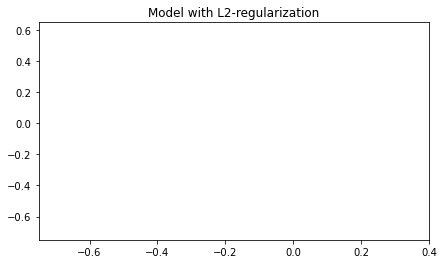

In [13]:
plt.title("Model with L2-regularization")
axes = plt.gca()
axes.set_xlim([-0.75,0.40])
axes.set_ylim([-0.75,0.65])
plot_decision_boundary(lambda x: predict_dec(parameters, x.T), train_X, train_Y)

### Dropout

- It randomly shuts down some neurons in each iteration.
- Should only use dropout (randomly eliminate nodes) in training. (Not in testing)

<center>
<video width="620" height="440" src="img/dropout1_kiank.mp4" type="video/mp4" controls>
</video>
</center>

<center>
<video width="620" height="440" src="img/dropout2_kiank.mp4" type="video/mp4" controls>
</video>
</center>

In [14]:
def forward_propagation_with_dropout(X, parameters, keep_prob = 0.5):
    """
    Implements the forward propagation: LINEAR -> RELU + DROPOUT -> LINEAR -> RELU + DROPOUT -> LINEAR -> SIGMOID.
    
    Arguments:
    X -- input dataset, of shape (2, number of examples)
    parameters -- python dictionary containing your parameters "W1", "b1", "W2", "b2", "W3", "b3":
                    W1 -- weight matrix of shape (20, 2)
                    b1 -- bias vector of shape (20, 1)
                    W2 -- weight matrix of shape (3, 20)
                    b2 -- bias vector of shape (3, 1)
                    W3 -- weight matrix of shape (1, 3)
                    b3 -- bias vector of shape (1, 1)
    keep_prob - probability of keeping a neuron active during drop-out, scalar
    
    Returns:
    A3 -- last activation value, output of the forward propagation, of shape (1,1)
    cache -- tuple, information stored for computing the backward propagation
    """
    
    np.random.seed(1)
    
    # retrieve parameters
    W1 = parameters["W1"]
    b1 = parameters["b1"]
    W2 = parameters["W2"]
    b2 = parameters["b2"]
    W3 = parameters["W3"]
    b3 = parameters["b3"]
    
    # LINEAR -> RELU -> LINEAR -> RELU -> LINEAR -> SIGMOID
    Z1 = np.dot(W1, X) + b1
    A1 = relu(Z1)
    
    # Steps 1-4 below correspond to the Steps 1-4 described above. 
    D1 = np.random.rand(A1.shape[0], A1.shape[1])     # Step 1: initialize matrix D1 = np.random.rand(..., ...)
    D1 = (D1 < keep_prob).astype(int)                 # Step 2: convert entries of D1 to 0 or 1 (using keep_prob as the threshold)
    A1 = A1 * D1                                      # Step 3: shut down some neurons of A1
    A1 = A1 / keep_prob                               # Step 4: scale the value of neurons that haven't been shut down
    
    Z2 = np.dot(W2, A1) + b2
    A2 = relu(Z2)
    
    D2 = np.random.rand(A2.shape[0], A2.shape[1])     # Step 1: initialize matrix D2 = np.random.rand(..., ...)
    D2 = (D2 < keep_prob).astype(int)                 # Step 2: convert entries of D2 to 0 or 1 (using keep_prob as the threshold)
    A2 = A2 * D2                                      # Step 3: shut down some neurons of A2
    A2 = A2 / keep_prob                               # Step 4: scale the value of neurons that haven't been shut down
    Z3 = np.dot(W3, A2) + b3
    A3 = sigmoid(Z3)
    
    cache = (Z1, D1, A1, W1, b1, Z2, D2, A2, W2, b2, Z3, A3, W3, b3)
    
    return A3, cache

In [15]:
def backward_propagation_with_dropout(X, Y, cache, keep_prob):
    """
    Implements the backward propagation of our baseline model to which we added dropout.
    
    Arguments:
    X -- input dataset, of shape (2, number of examples)
    Y -- "true" labels vector, of shape (output size, number of examples)
    cache -- cache output from forward_propagation_with_dropout()
    keep_prob - probability of keeping a neuron active during drop-out, scalar
    
    Returns:
    gradients -- A dictionary with the gradients with respect to each parameter, activation and pre-activation variables
    """
    
    m = X.shape[1]
    (Z1, D1, A1, W1, b1, Z2, D2, A2, W2, b2, Z3, A3, W3, b3) = cache
    
    dZ3 = A3 - Y
    dW3 = 1./m * np.dot(dZ3, A2.T)
    db3 = 1./m * np.sum(dZ3, axis=1, keepdims = True)
    dA2 = np.dot(W3.T, dZ3)
    
    dA2 = dA2 * D2              # Step 1: Apply mask D2 to shut down the same neurons as during the forward propagation
    dA2 = dA2 / keep_prob              # Step 2: Scale the value of neurons that haven't been shut down
    
    dZ2 = np.multiply(dA2, np.int64(A2 > 0))
    dW2 = 1./m * np.dot(dZ2, A1.T)
    db2 = 1./m * np.sum(dZ2, axis=1, keepdims = True)
    
    dA1 = np.dot(W2.T, dZ2)
    
    dA1 = dA1 * D1              # Step 1: Apply mask D1 to shut down the same neurons as during the forward propagation
    dA1 = dA1 / keep_prob              # Step 2: Scale the value of neurons that haven't been shut down
    
    dZ1 = np.multiply(dA1, np.int64(A1 > 0))
    dW1 = 1./m * np.dot(dZ1, X.T)
    db1 = 1./m * np.sum(dZ1, axis=1, keepdims = True)
    
    gradients = {"dZ3": dZ3, "dW3": dW3, "db3": db3,"dA2": dA2,
                 "dZ2": dZ2, "dW2": dW2, "db2": db2, "dA1": dA1, 
                 "dZ1": dZ1, "dW1": dW1, "db1": db1}
    
    return gradients

In [16]:
parameters = model(train_X, train_Y, keep_prob = 0.86, learning_rate = 0.3)
print ("On the train set:")
predictions_train = predict(train_X, train_Y, parameters)
print ("On the test set:")
predictions_test = predict(test_X, test_Y, parameters)

NameError: name 'train_X' is not defined

NameError: name 'train_X' is not defined

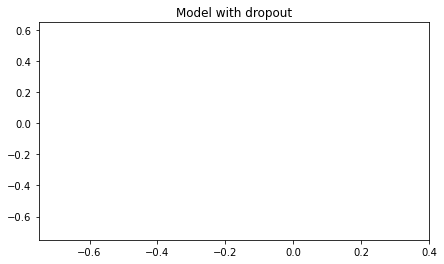

In [17]:
plt.title("Model with dropout")
axes = plt.gca()
axes.set_xlim([-0.75,0.40])
axes.set_ylim([-0.75,0.65])
plot_decision_boundary(lambda x: predict_dec(parameters, x.T), train_X, train_Y)

### Conclusions

**Here are the results of our three models**: 

<table> 
    <tr>
        <td>
        **model**
        </td>
        <td>
        **train accuracy**
        </td>
        <td>
        **test accuracy**
        </td>
    </tr>
        <td>
        3-layer NN without regularization
        </td>
        <td>
        95%
        </td>
        <td>
        91.5%
        </td>
    <tr>
        <td>
        3-layer NN with L2-regularization
        </td>
        <td>
        94%
        </td>
        <td>
        93%
        </td>
    </tr>
    <tr>
        <td>
        3-layer NN with dropout
        </td>
        <td>
        93%
        </td>
        <td>
        95%
        </td>
    </tr>
</table> 